# Automated Image Colorization
---

**MOST IMPORTANT NOTE:**
Built off the ***https://github.com/hanzhao/image-colorization*** baseline!

## Motivation

The motivation for this project is to solve a real-world problem, which aims to recover the colorized images from monochrome (black-and-white) ones. We have huge amounts of images and videos from older generations that were captured in grayscale, from personal family photos to recordings of historic events like the 1929 stock market crash or World War II. Those monochrome images captured invaluable memories of individuals and generations, and they could be even more impressive if we could recover the colorized version by applying the latest techniques.

## Environment Setup

In [ ]:
# Ensure we have GPU set up. It could be skipped for inference.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Apr 18 12:52:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!python --version

Python 3.7.13


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [ ]:
!pip install tensorflow-io tensorboardcolab tensorflow-addons &> /dev/null

In [ ]:
import tensorflow_io as tfio
import tensorflow_addons as tfa
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import auth
auth.authenticate_user()

## Data Preparation

There are lots of possible datasets which could be used for this dataset, but we are looking into diversified data set containing real world images. Through out the experiments, we explored and tried out the solution on the following 3 datasets, in order,

*   Validation Set of ImageNet 2012
*   Food 101
*   Places 365

Finally, Places 365 Small data set was preferred because of its rich contents as well as a balanced size. Previous two data sets are mainly used for data exploration and idea validation during the development.

To make sure easy integration with models, all images in those datasets will be scaled into `(224, 224)` with exactly same batch size. Data argumentation might be performed for better model generalization.

### Data Load

Please run only one following dataset loading section at one time since variables are shared.

In [ ]:
# Batch size for using GPU accelerator in Colab. Untuned.
BATCH_SIZE = 32

#### Places 365 (Selected)

Places contains more than 10 million images comprising 400+ unique scene categories. The dataset features 5000 to 30,000 training images per class, consistent with real-world frequencies of occurrence. The variant we used in experiment resized image to `(256, 256)` regardless of the original aspect ratio.

|  Data Split  |   # Images   |     Size     |
| ------------ | ------------ | ------------ |
| Training     |  1,803,460   |    24 GB     |
| Validation   |     36,500   |   0.5 GB     |
| Test         |    328,500   |     4 GB     |

Note: It may take a long time (about 30 min) to load this data set in Colab, even with the data pre-downloaded into Drive.

In [ ]:
USE_GCS = False

if not USE_GCS:
  # Run if data has been downloaded into Google Drive.
  !mkdir -p ~/tensorflow_datasets/downloads/
#  !mkdir -p /content/drive/MyDrive/Dataset/places365_small/*
#  !cp /content/drive/MyDrive/Dataset/places365_small/* ~/tensorflow_datasets/downloads/

In [ ]:
import tensorflow_datasets as tfds

if USE_GCS:
  dataset, info = tfds.load('places365_small', as_supervised=True, with_info=True, data_dir='gs://tensorflow_datasets_cs229')
else:
  dataset, info = tfds.load('places365_small', split=['train[:3%]', 'validation[:3%]', 'test[:3%]'], as_supervised=True, with_info=True)
  # added the split line for testing less data:  split="train[:1%]",

raw_training_dataset, raw_validation_dataset, raw_test_dataset = dataset[0], dataset[1], dataset[2]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/places365_small/2.0.0.incompleteF0Y4QZ/places365_small-train.tfrecord


  0%|          | 0/1803460 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/places365_small/2.0.0.incompleteF0Y4QZ/places365_small-test.tfrecord


  0%|          | 0/328500 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/places365_small/2.0.0.incompleteF0Y4QZ/places365_small-validation.tfrecord


  0%|          | 0/36500 [00:00<?, ? examples/s]

Dataset places365_small downloaded and prepared to /root/tensorflow_datasets/places365_small/2.0.0. Subsequent calls will reuse this data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Enable data argumentation.
ENABLE_DATA_ARGUMENTATION = True
# Enable batching.
ENABLE_BATCH = True
DATA_SET_NAME = 'places'

#### ImageNet Validation Set (Trial)
The ImageNet (ILSVRC2012) is a huge data set reflecting the real world scenes. But due to the limit of our experiment environment (Google Colab), we were not able to load the whole training set (~140 GB, 1.28M images) into the machine. Instead, we used the original validation set (6 GB, 50K images) of ImageNet and split it into 9:1 for training and test purpose.

|  Data Split  |   # Images   |     Size     |
| ------------ | ------------ | ------------ |
| Training     |   45,000     |   5.4 GB     |
| Validation   |    5,000     |   0.6 GB     |

To load the data in Colab, download `ILSVRC2012_img_val.tar` from ImageNet website and upload into Google Drive path `Dataset/ILSVRC2012_img_val.tar`.

In [ ]:
import tarfile
with tarfile.open('/content/drive/MyDrive/Dataset/ILSVRC2012_img_val.tar') as tar:
  tar.extractall('/tmp/imagenet/validation')

In [ ]:
import pathlib
IMAGE_DIR = '/tmp/imagenet'

image_count = len(list(pathlib.Path(IMAGE_DIR).glob('*/*.JPEG')))
print(f'Total image count: {image_count}')

In [ ]:
# Use ImageDataGenerator to stream images for ImageNet.
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1)
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1)

raw_training_dataset = tf.data.Dataset.from_generator(
    lambda: training_datagen.flow_from_directory(
        IMAGE_DIR, IMAGE_SIZE,
        seed=229, subset='training', batch_size=BATCH_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.uint8)))
raw_validation_dataset = tf.data.Dataset.from_generator(
    lambda: validation_datagen.flow_from_directory(
        IMAGE_DIR, IMAGE_SIZE,
        seed=229, subset='validation', batch_size=BATCH_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.uint8)))

In [ ]:
# Enable data argumentation.
ENABLE_DATA_ARGUMENTATION = True
# Disable further batching. The data has been batched.
ENABLE_BATCH = False
DATA_SET_NAME = 'image_net'

#### Food 101 (Trial)

The Food-101 Data Set provided us a comprehensive image set with 101,000 images for 101 food categories. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

|  Data Split  |   # Images   |     Size     |
| ------------ | ------------ | ------------ |
| Training     |   75,750     |   4.5 GB     |
| Validation   |   25,250     |   0.5 GB     |

In [ ]:
# Run if data has been downloaded into Google Drive.
!mkdir -p ~/tensorflow_datasets/downloads/
#!mkdir -p /content/drive/MyDrive/Dataset/food101/*
#!cp /content/drive/MyDrive/Dataset/food101/* ~/tensorflow_datasets/downloads/

In [ ]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('food101', as_supervised=True, with_info=True)
raw_training_dataset, raw_validation_dataset = dataset['train'], dataset['validation']

In [ ]:
# Enable data argumentation.
ENABLE_DATA_ARGUMENTATION = True
# Enable batching.
ENABLE_BATCH = True
DATA_SET_NAME = 'food'

### Data Argumentation and Normalization

The first two datasets we explored were relatively small, which made us believe data argumentation would be a good way to achieve better generalization. Two argumentation approaches were explored,

*   Horizontal Flipping
*   Rotation

For generating and normalizating data, we need to transformed original images in datasets to grayscale images, either by picking `L*` component in CIELab color space or `Y` component in YUV color space. The grayscale image will be represented as `(224, 224, 1)` floating number matrix whose all values are within `[0, 1]`.

For modeling the output of model, we explored both YUV color space and CIELab color space. It turned out both were proved effective for this problem setting by previous implementation and papers. Given CIELab is a color space more related to human's perception by definition, we finally chose CIELab color space as main approach. YUV color space was used to reproduce some baseline models.

In CIELab color space, `L*` component could range from 0 to 100, denoting the lightness. `a*` and `b*` axes are unbounded, but often be clamped into the range of −128 to 127. In our model, `L*` will be normalized into `[0, 1]` and fed into the model to mimic grayscale input, and `a*`, `b*` will be normalized into `[-1, 1]` as the model output.

In YUV color space, `Y` component could range from 0 to 1, denoting the lightness. `U` and `V` axes range from -0.5 to 0.5.

To recover the output as RGB images, those three components need to be unnormalized (if applicable), combined and transformed back into RGB color space.

In [ ]:
def transform_from_rgb_color_space_and_decompose(image, color_space):
  """

  Tranforms the RGB image into CIELab or YUV color space, and decomposes the
  output channels into luminance channel and color channels.

  Args:
    image: 3D or 4D input tensor, representing image or batched images with 3
           channels. Users need to convert the input image into a float [0, 1]
           range.
    color_space (str): 'lab' or 'yuv'
  
  Returns:
    A tuple of two tensors. The first tensor has only one channel with values
    within [0, 1], denoting the luminance. The second tensor has two channels.
    If the target color space is CIELab, the values of second tensor are in the
    range of [-1, 1].
    If the target color space is YUV, the values of second tensor are in the
    range of [-0.5, 0.5].

  """
  if color_space == 'lab':
    lab = tfio.experimental.color.rgb_to_lab(image)
    l = lab[..., :1] / 100.
    ab = lab[..., 1:] / 128.
    return (l, ab)
  if color_space == 'yuv':
    yuv = tf.image.rgb_to_yuv(image)
    y = yuv[..., :1]
    uv = yuv[..., 1:]
    return (y, uv)
  raise ValueError(f'Unrecognized color space: {color_space}')

def compose_and_transform_to_rgb_color_space(tensors, from_color_space):
  """

  Composes luminance channel and color channels of image and transforms that
  back to RGB color space.

  Args:
    tensors: Tuple of two 3D or 4D input tensors, representing luminance channel
             and color channels of the image. The first tensor should have only
             1 channel, and second tensor should have 2 channels.
    from_color_space (str): 'lab' or 'yuv'
  
  Returns:
    A tensor with 3 channels representing RGB image(s). The values of the output
    tensor are in the range of [0, 1].

  """
  if from_color_space == 'lab':
    return tfio.experimental.color.lab_to_rgb(
        tf.concat([tensors[0] * 100, tensors[1] * 128], -1))
  if from_color_space == 'yuv':
    return tf.image.yuv_to_rgb(tf.concat(tensors, -1))
  raise ValueError(f'Unrecognized color space: {from_color_space}')

def transform_dataset(data_set,
                      enable_data_argumentation=False,
                      enable_batch=False,
                      color_space='lab'):
  """

  Constructs the data set generation pipeline.

  Args:
    data_set (tf.data.Dataset): The input data set, which should be RGB images
                                with arbitary labels.
    use_data_argumentation (bool): Enables data argumentation.

  Returns:
    A tf.data.Dataset with luminance channel as input and color channels as
    labels.
    Input will be in the shape of (None, 224, 224, 1). 
    Labels will be in the shape of (None, 224, 224, 2). 

  """
  # Cast to float32 and resize it.
  data_set = data_set.map(lambda x, y:
      (tf.image.resize(tf.cast(x, tf.dtypes.float32), (224, 224)), y))
  
  # Batch.
  if enable_batch:
    data_set = data_set.batch(BATCH_SIZE)

  # Data argumentation: flipping and rotating.
  if enable_data_argumentation:
    data_argumentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ])
    data_set = data_set.map(lambda x, y: (data_argumentation(x), y))
  
  # Transform into CIELab color space and decompose into input and labels.
  data_set = data_set.map(lambda x, _:
      transform_from_rgb_color_space_and_decompose(x / 255., color_space=color_space))

  return data_set.prefetch(tf.data.AUTOTUNE)

In [ ]:
EFFECTIVE_COLOR_SPACE = 'lab'
# EFFECTIVE_COLOR_SPACE = 'yuv'

training_dataset = transform_dataset(
    raw_training_dataset,
    enable_data_argumentation=ENABLE_DATA_ARGUMENTATION,
    enable_batch=ENABLE_BATCH,
    color_space=EFFECTIVE_COLOR_SPACE)
validation_dataset = transform_dataset(
    raw_validation_dataset,
    enable_data_argumentation=False,
    enable_batch=ENABLE_BATCH,
    color_space=EFFECTIVE_COLOR_SPACE)
if 'raw_test_dataset' in locals():
  test_dataset = transform_dataset(
    raw_test_dataset,
    enable_data_argumentation=False,
    enable_batch=ENABLE_BATCH,
    color_space=EFFECTIVE_COLOR_SPACE)

To verify the correctness of data pipelines and get basic sense of the data set, let's spot check a few images after processing for both training and validation set. The grayscale image (left) will be the input and the colored image (right) will be the desired output.

Showing 16 samples from training set


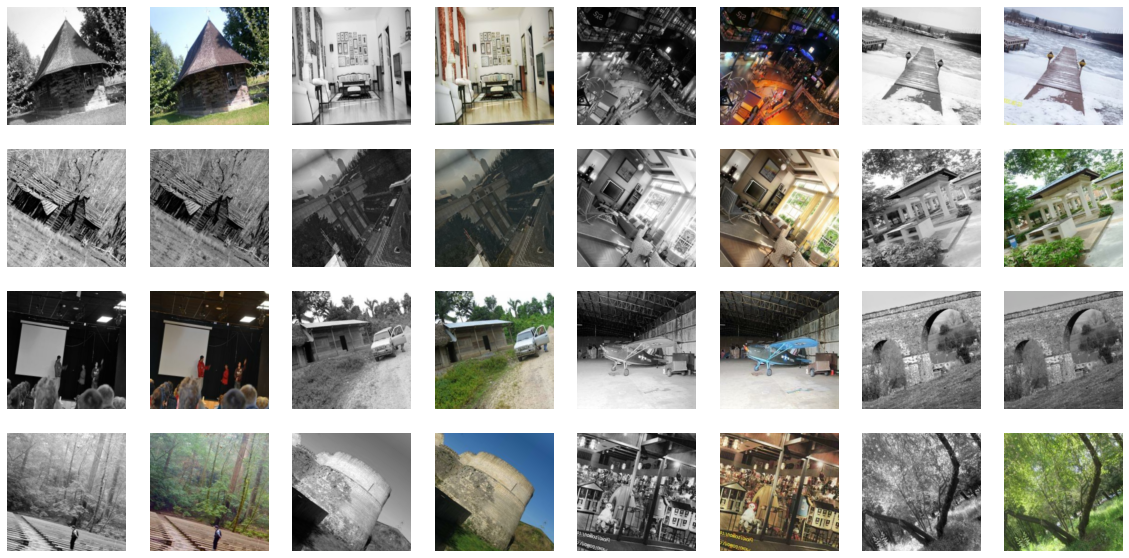

In [ ]:
import math
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for x, y in training_dataset.take(1):
  n = min(x.shape[0], 16)
  print(f'Showing {n} samples from training set')
  for i in range(n):
    # x: input, grayscale
    plt.subplot(4, 8, i * 2 + 1)
    plt.imshow(tf.squeeze(x[i]), cmap='gray')
    plt.axis('off')
    # y: ground truth
    plt.subplot(4, 8, i * 2 + 2)
    plt.imshow(compose_and_transform_to_rgb_color_space((x[i], y[i]), EFFECTIVE_COLOR_SPACE))
    plt.axis('off')

Showing 16 samples from validation set


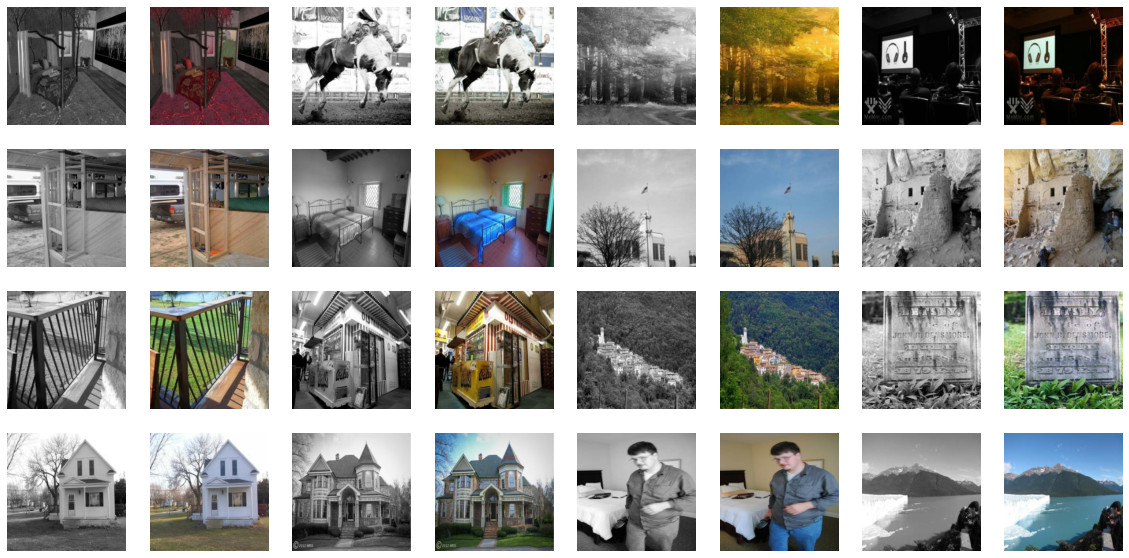

In [ ]:
import math
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for x, y in validation_dataset.take(1):
  n = min(x.shape[0], 16)
  print(f'Showing {n} samples from validation set')
  for i in range(n):
    # x: input, grayscale
    plt.subplot(4, 8, i * 2 + 1)
    plt.imshow(tf.squeeze(x[i]), cmap='gray')
    plt.axis('off')
    # y: ground truth
    plt.subplot(4, 8, i * 2 + 2)
    plt.imshow(compose_and_transform_to_rgb_color_space((x[i], y[i]), EFFECTIVE_COLOR_SPACE))
    plt.axis('off')

## Models and Experiments

### Objective Function

The loss function widely used by most implementation is
$$\mathcal{L}(\hat{Y}, Y) = \frac{1}{2} \sum_{h,w}||Y_{h,w} - \hat{Y}_{h,w}||_2^2$$

But in our experiment, this objective function tends to produce unsaturated output images. After adding color rebalance, the loss function is
$$\mathcal{L}(\hat{Y}, Y) = \frac{1}{2} \sum_{h,w} v(Y_{h,w}) ||Y_{h,w} - \hat{Y}_{h,w}||_2^2$$

### Model Architecture

We've tried several different model architectures, including

*   Naive ConvNet
*   ConvNet with VGG-16 Feature Extractor ([Automatic Colorization](https://tinyclouds.org/colorize/))
*   ConvNet with EfficientNet Feature Extractor

| Model                                    | Total Params | Trainable Params |
|------------------------------------------|-------------:|-----------------:|
| Naive ConvNet                            |   12,567,716 |       12,567,716 |
| ConvNet + VGG-16 Feature Extractor       |    8,142,963 |          504,865 |
| ConvNet + EfficientNet Feature Extractor |   75,395,353 |       11,292,674 |

#### Model Utilities

In [ ]:
def get_checkpoint_path(model_name):
  return '/content/drive/MyDrive/cs229_model_checkpoints/' + model_name + '/' + DATA_SET_NAME + '_model_{epoch:02d}_{val_loss:.6f}.hdf5'

def get_saved_model_path(model_name):
  return f'/content/drive/MyDrive/cs229_models/{model_name}/{DATA_SET_NAME}_saved_model_weights.hdf5'

#### Naive ConvNet

This model is being used as a baseline, which utilizes 5 Conv2D layers as feature encoder and 5 Conv2DTranspose layers as feature decoder.

In [ ]:
def build_naive_cnn_model():
  # Input layer
  input = tf.keras.layers.Input((224, 224, 1))

  # Encoders
  x = tf.keras.layers.Conv2D(64, (3, 3), 2, padding='same')(input) # (224, 224) -> (112, 112)
  x = tf.keras.layers.BatchNormalization()(x)
  conv_activation_112x112 = tf.keras.layers.ReLU()(x)

  x = tf.keras.layers.Conv2D(128, (3, 3), 2, padding='same')(conv_activation_112x112) # (112, 112) -> (56, 56)
  x = tf.keras.layers.BatchNormalization()(x)
  conv_activation_56x56 = tf.keras.layers.ReLU()(x)

  x = tf.keras.layers.Conv2D(256, (3, 3), 2, padding='same')(conv_activation_56x56) # (56, 56) -> (28, 28)
  x = tf.keras.layers.BatchNormalization()(x)
  conv_activation_28x28 = tf.keras.layers.ReLU()(x)

  x = tf.keras.layers.Conv2D(512, (3, 3), 2, padding='same')(conv_activation_28x28) # (28, 28) -> (14, 14)
  x = tf.keras.layers.BatchNormalization()(x)
  conv_activation_14x14 = tf.keras.layers.ReLU()(x)

  x = tf.keras.layers.Conv2D(1024, (3, 3), 2, padding='same')(conv_activation_14x14) # (14, 14) -> (7, 7)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  
  # Decoders
  x = tf.keras.layers.Conv2DTranspose(512, (3, 3), 2, padding='same')(x) # (7, 7) -> (14, 14)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.add(x, conv_activation_14x14)

  x = tf.keras.layers.Conv2DTranspose(256, (3, 3), 2, padding='same')(x) # (14, 14) -> (28, 28)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.add(x, conv_activation_28x28)

  x = tf.keras.layers.Conv2DTranspose(128, (3, 3), 2, padding='same')(x) # (28, 28) -> (56, 56)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.add(x, conv_activation_56x56)

  x = tf.keras.layers.Conv2DTranspose(64, (3, 3), 2, padding='same')(x) # (56, 56) -> (112, 112)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.add(x, conv_activation_112x112)

  x = tf.keras.layers.Conv2DTranspose(32, (3, 3), 2, padding='same')(x) # (112, 112) -> (224, 224)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.concatenate([x, input])

  output = tf.keras.layers.Conv2D(2, (1, 1), activation='tanh')(x)

  return tf.keras.models.Model(input, output)

cnn_model_naive = build_naive_cnn_model()

In [ ]:
cnn_model_naive.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
cnn_model_naive.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Load saved model weights.
cnn_model_naive.load_weights(get_saved_model_path('cnn_model_naive'))

In [ ]:
cnn_model_naive_checkpoint_path = get_checkpoint_path('cnn_model_naive')

In [ ]:
assert EFFECTIVE_COLOR_SPACE == 'lab'

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=cnn_model_naive_checkpoint_path,
    verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    '/tmp/tensorboard_logs/cnn_model_naive',
    histogram_freq=1)

cnn_model_naive_history = cnn_model_naive.fit(
    training_dataset,
    validation_data=validation_dataset,
    shuffle=True,
    epochs=20,
    callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/20
5636/5636 [==============================] - ETA: 0s - loss: 0.0099
Epoch 1: saving model to /content/drive/MyDrive/cs229_model_checkpoints/cnn_model_naive/places_model_01_0.011073.hdf5
5636/5636 [==============================] - 1510s 266ms/step - loss: 0.0099 - val_loss: 0.0111
Epoch 2/20
5636/5636 [==============================] - ETA: 0s - loss: 0.0097
Epoch 2: saving model to /content/drive/MyDrive/cs229_model_checkpoints/cnn_model_naive/places_model_02_0.011504.hdf5
5636/5636 [==============================] - 1546s 274ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 3/20
5636/5636 [==============================] - ETA: 0s - loss: 0.0095
Epoch 3: saving model to /content/drive/MyDrive/cs229_model_checkpoints/cnn_model_naive/places_model_03_0.010344.hdf5
5636/5636 [==============================] - 1546s 274ms/step - loss: 0.0095 - val_loss: 0.0103
Epoch 4/20
5636/5636 [==============================] - ETA: 0s - loss: 0.0094
Epoch 4: saving model to /content/drive/My

### ConvNet + ResNet152V2 Implementation, Modeled after the EfficentNet Feature Extractor
My Model!

In [ ]:
def build_feature_extractor():
  # Pretrained EfficientNet B7
  # It's very interesting that they customized B7, despite B0 being the 
  # EfficentNet that already uses 244 x 244 images
  efficient_net = tf.keras.applications.EfficientNetB7(
      include_top=False,
      input_shape=(224, 224, 3),
      weights='imagenet')
  return tf.keras.models.Model(
      efficient_net.input, {
          'embedding_112x112': efficient_net.get_layer('block2a_expand_activation').output,
          'embedding_56x56': efficient_net.get_layer('block3a_expand_activation').output,
          'embedding_28x28': efficient_net.get_layer('block4a_expand_activation').output,
          'embedding_14x14': efficient_net.get_layer('block6a_expand_activation').output,
          'embedding_7x7': efficient_net.get_layer('top_activation').output,
      }, name='TroyNetFeatureExtractor')

def build_Troy_net_colorizer():
  # Input layer
  input = tf.keras.layers.Input((224, 224, 1))
  efficient_net_input = tf.image.grayscale_to_rgb(input) * 255.

  efficient_net = build_feature_extractor()
  efficient_net.trainable = False
  embeddings = efficient_net(efficient_net_input, training=False)

  #preemptive dropout layer, all should be in the fully connected layers in n > 0.5
  #otherwise this is fine, helps vary the model
  x = tf.keras.layers.Dropout(0.2, input_shape=(244, 244, 1))

  # 7x7
  x = tf.keras.layers.Conv2D(1344, (1, 1), padding='same')(embeddings['embedding_7x7'])
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 14x14
  x = tf.add(tf.keras.layers.UpSampling2D()(x), embeddings['embedding_14x14'])
  x = tf.keras.layers.Conv2D(480, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 28x28
  x = tf.add(tf.keras.layers.UpSampling2D()(x), embeddings['embedding_28x28'])
  x = tf.keras.layers.Conv2D(288, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 56x56
  x = tf.add(tf.keras.layers.UpSampling2D()(x), embeddings['embedding_56x56'])
  x = tf.keras.layers.Conv2D(192, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 112x112
  x = tf.add(tf.keras.layers.UpSampling2D()(x), embeddings['embedding_112x112'])
  x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 224x224
  x = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D()(x), input])
  x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  
  x = tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation='tanh')(x)
  output = x

  return (tf.keras.models.Model(input, output), efficient_net)

In [ ]:
Troy_Net_colorizer, Troy_net = build_Troy_net_colorizer()

Troy_Net_colorizer.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['accuracy'])
Troy_Net_colorizer.summary()

258088960/258076736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.grayscale_to_rgb (TFO  (None, 224, 224, 3)  0          ['input_2[0][0]']                
 pLambda)                                                                                         
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.image.grayscale_to_rgb[0][0]
                         

In [ ]:
# Load saved model weights.
Troy_Net_colorizer.load_weights(get_saved_model_path('Troy_Net_colorizer'))

In [ ]:
Troy_Net_colorizer_checkpoint_path = get_checkpoint_path('Troy_Net_colorizer')

In [ ]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=Troy_Net_colorizer_checkpoint_path,
    save_weights_only=True,
    verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    '/tmp/tensorboard_logs/Troy_Net_colorizer',
    histogram_freq=1)

#implement early stopping here, apply it to checkpoint parameters
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=2, 
    #min_delta=0.001, 
    mode='auto' #uses min for loss or max for accuracy by default
)

history = Troy_Net_colorizer.fit(
    training_dataset,
    validation_data=validation_dataset,
    shuffle=True,
    epochs=20,
    callbacks=[early_stopping, checkpoint_callback, tensorboard_callback])
#Each Epoch takes about 4:35 mins, not accounting for how many epochs

Epoch 1/20
5636/5636 [==============================] - ETA: 0s - loss: 0.0091 - accuracy: 0.7168
Epoch 1: saving model to /content/drive/MyDrive/cs229_model_checkpoints/Troy_Net_colorizer/places_model_01_0.008886.hdf5
5636/5636 [==============================] - 2801s 493ms/step - loss: 0.0091 - accuracy: 0.7168 - val_loss: 0.0089 - val_accuracy: 0.7038
Epoch 2/20
5636/5636 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.7213
Epoch 2: saving model to /content/drive/MyDrive/cs229_model_checkpoints/Troy_Net_colorizer/places_model_02_0.008511.hdf5
5636/5636 [==============================] - 2798s 496ms/step - loss: 0.0086 - accuracy: 0.7213 - val_loss: 0.0085 - val_accuracy: 0.7205
Epoch 3/20
5636/5636 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.7236
Epoch 3: saving model to /content/drive/MyDrive/cs229_model_checkpoints/Troy_Net_colorizer/places_model_03_0.008509.hdf5
5636/5636 [==============================] - 2792s 495ms/step - los

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model Loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(history)

#### ConvNet + VGG-16 Feature Extractor

This model replicates the idea proposed in [Automatic Colorization](https://tinyclouds.org/colorize/) by Ryan Dahl. Instead of utilizing only one layer of feature output, this model suggested multiple layers with different resolutions might all be useful. So it leverages the intermediate output of 4 inner layers from VGG-16 model to generate the final output. By utilizing transfer learning, this approach greatly reduces the model complexity and leads faster convergence.

This model assumes the input/output is in YUV color space.

In [ ]:
def build_feature_extractor():
  vgg16 = tf.keras.applications.VGG16(
      include_top=False,
      input_shape=(224, 224, 3),
      weights='imagenet')
  return tf.keras.models.Model(
      vgg16.input, {
          'embedding_224x224': vgg16.get_layer('block1_conv2').output,
          'embedding_112x112': vgg16.get_layer('block2_conv2').output,
          'embedding_56x56': vgg16.get_layer('block3_conv3').output,
          'embedding_28x28': vgg16.get_layer('block4_conv3').output,
      }, name='VGG16FeatureExtractor')

def build_vgg16_colorizer():
  # Input layer
  input = tf.keras.layers.Input((224, 224, 1))
  vgg16_input = tf.keras.applications.vgg16.preprocess_input(tf.image.grayscale_to_rgb(input) * 255.)

  vgg16 = build_feature_extractor()
  vgg16.trainable = False
  embeddings = vgg16(vgg16_input, training=False)

  # 28x28
  x = tf.keras.layers.BatchNormalization()(embeddings['embedding_28x28'])
  x = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 56x56
  x = tf.add(tf.keras.layers.UpSampling2D()(x),
             tf.keras.layers.BatchNormalization()(embeddings['embedding_56x56']))
  x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 112x112
  x = tf.add(tf.keras.layers.UpSampling2D()(x),
             tf.keras.layers.BatchNormalization()(embeddings['embedding_112x112']))
  x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 224x224
  x = tf.add(tf.keras.layers.UpSampling2D()(x),
             tf.keras.layers.BatchNormalization()(embeddings['embedding_224x224']))
  x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  
  # 224x224
  x = tf.add(x,
             tf.keras.layers.BatchNormalization()(vgg16_input))
  x = tf.keras.layers.Conv2D(3, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  
  x = tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation='sigmoid')(x)
  
  output = x - 0.5

  return (tf.keras.models.Model(input, output), vgg16)

vgg16_colorizer, vgg16 = build_vgg16_colorizer()

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_colorizer.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
vgg16_colorizer.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.grayscale_to_rgb (TFO  (None, 224, 224, 3)  0          ['input_2[0][0]']                
 pLambda)                                                                                         
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 224, 224, 3)  0           ['tf.image.grayscale_to_rgb[0][0]
                                                                 ']                         

In [ ]:
# Load saved model weights.
vgg16_colorizer.load_weights(get_saved_model_path('vgg16_colorizer'))

OSError: ignored

In [ ]:
vgg16_colorizer_checkpoint_path = get_checkpoint_path('vgg16_colorizer')

In [ ]:
assert EFFECTIVE_COLOR_SPACE == 'yuv'

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=vgg16_colorizer_checkpoint_path,
    save_weights_only=True,
    verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    '/tmp/tensorboard_logs/vgg16_colorizer',
    histogram_freq=1)

history = vgg16_colorizer.fit(
    training_dataset,
    validation_data=validation_dataset,
    shuffle=True,
    epochs=10,
    callbacks=[checkpoint_callback, tensorboard_callback])

AssertionError: ignored

#### ConvNet + EffientNet Feature Extractor

This model followed the idea proposed in [Automatic Colorization](https://tinyclouds.org/colorize/) by Ryan Dahl, and made following enhancements.

**Color Space**

Given CIELab is a color space more related to human's perception by definition, we finally chose CIELab color space to replace YUV color space.

**Sub-model for Feature Extraction**

The pretrained model originally proposed was VGG-16. We replaced VGG-16 with [EfficientNet](https://arxiv.org/abs/1905.11946) and adjusted the model architecture accordingly. EfficientNet is used because of a few its advantages,
1.   EfficientNet achieved SOTA benchmark results in original ImageNet evaluation (Top-1 Accuracy: 84.3% vs. 71.3%; Top-5 Accuracy: 97.0% vs 90.1%).
2.   EfficientNet also has well-defined intermediate feature layers, named `endpoints['reduction_i']` in the original implementation. Those layers have similar shape with VGG-16 and are also suggested by original authors to be useful for transfer learning.

This model takes 10-15 min for one epoch on ImageNet validation set or Food 101 data set, 4h on Places 365 data set. Generally, the model converges and find best model (w.r.t. validation set) in less than 5 epochs.

##### Approach 1: MSE as Loss Function

In [ ]:
def build_feature_extractor():
  # Pretrained EfficientNet B7
  efficient_net = tf.keras.applications.EfficientNetB7(
      include_top=False,
      input_shape=(224, 224, 3),
      weights='imagenet')
  return tf.keras.models.Model(
      efficient_net.input, {
          'embedding_112x112': efficient_net.get_layer('block2a_expand_activation').output,
          'embedding_56x56': efficient_net.get_layer('block3a_expand_activation').output,
          'embedding_28x28': efficient_net.get_layer('block4a_expand_activation').output,
          'embedding_14x14': efficient_net.get_layer('block6a_expand_activation').output,
          'embedding_7x7': efficient_net.get_layer('top_activation').output,
      }, name='EfficientNetFeatureExtractor')

def build_efficient_net_colorizer():
  # Input layer
  input = tf.keras.layers.Input((224, 224, 1))
  efficient_net_input = tf.image.grayscale_to_rgb(input) * 255.

  efficient_net = build_feature_extractor()
  efficient_net.trainable = False
  embeddings = efficient_net(efficient_net_input, training=False)

  # 7x7
  x = tf.keras.layers.Conv2D(1344, (1, 1), padding='same')(embeddings['embedding_7x7'])
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 14x14
  x = tf.add(tf.keras.layers.UpSampling2D()(x), embeddings['embedding_14x14'])
  x = tf.keras.layers.Conv2D(480, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 28x28
  x = tf.add(tf.keras.layers.UpSampling2D()(x), embeddings['embedding_28x28'])
  x = tf.keras.layers.Conv2D(288, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 56x56
  x = tf.add(tf.keras.layers.UpSampling2D()(x), embeddings['embedding_56x56'])
  x = tf.keras.layers.Conv2D(192, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 112x112
  x = tf.add(tf.keras.layers.UpSampling2D()(x), embeddings['embedding_112x112'])
  x = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  # 224x224
  x = tf.keras.layers.concatenate([tf.keras.layers.UpSampling2D()(x), input])
  x = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  
  x = tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation='tanh')(x)
  output = x

  return (tf.keras.models.Model(input, output), efficient_net)

In [ ]:
efficient_net_colorizer, efficient_net = build_efficient_net_colorizer()


efficient_net_colorizer.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['accuracy'])
efficient_net_colorizer.summary()

258088960/258076736 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.grayscale_to_rgb_1 (T  (None, 224, 224, 3)  0          ['input_4[0][0]']                
 FOpLambda)                                                                                       
                                                                                                  
 tf.math.multiply_1 (TFOpLambda  (None, 224, 224, 3)  0          ['tf.image.grayscale_to_rgb_1[0][
 )                       

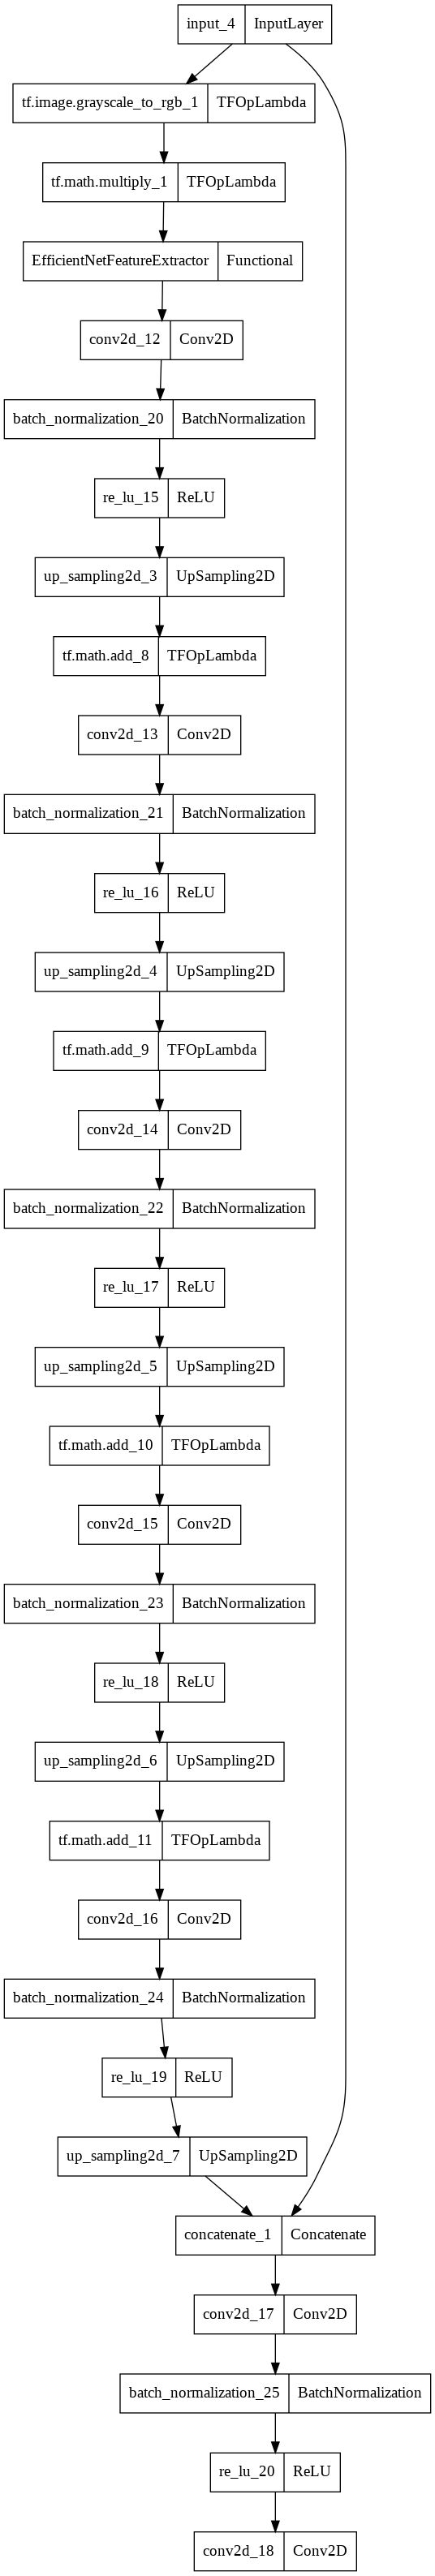

In [ ]:
tf.keras.utils.plot_model(efficient_net_colorizer)

In [ ]:
# Load saved model weights.
efficient_net_colorizer.load_weights(get_saved_model_path('efficient_net_colorizer'))

In [ ]:
efficient_net_colorizer_checkpoint_path = get_checkpoint_path('efficient_net_colorizer')

In [ ]:
import datetime

assert EFFECTIVE_COLOR_SPACE == 'lab'

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=efficient_net_colorizer_checkpoint_path,
    save_weights_only=True,
    verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    f'/tmp/tensorboard_logs/efficient_net_colorizer/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}',
    histogram_freq=1)

history = efficient_net_colorizer.fit(
    training_dataset,
    validation_data=validation_dataset,
    shuffle=True,
    epochs=10,
    callbacks=[checkpoint_callback, tensorboard_callback])
# ETA: 4:30 per epoch.

Epoch 1/10
1691/1691 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.7156
Epoch 1: saving model to /content/drive/MyDrive/cs229_model_checkpoints/efficient_net_colorizer/places_model_01_0.009490.hdf5
1691/1691 [==============================] - 879s 503ms/step - loss: 0.0092 - accuracy: 0.7156 - val_loss: 0.0095 - val_accuracy: 0.7146
Epoch 2/10
1691/1691 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.7190
Epoch 2: saving model to /content/drive/MyDrive/cs229_model_checkpoints/efficient_net_colorizer/places_model_02_0.008869.hdf5
1691/1691 [==============================] - 846s 500ms/step - loss: 0.0089 - accuracy: 0.7190 - val_loss: 0.0089 - val_accuracy: 0.7135
Epoch 3/10
1691/1691 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.7208
Epoch 3: saving model to /content/drive/MyDrive/cs229_model_checkpoints/efficient_net_colorizer/places_model_03_0.008563.hdf5
1691/1691 [==============================] - 846s 500m

##### Approach 2: Weighted Loss Based on Color Rarity

This model uses same architecture as above, but also leverages the idea from [Colorful Image Colorization](https://arxiv.org/abs/1603.08511) to accumulate weighted loss for different pixels. We went through all color pixels in the training set, and calculated $p(a, b)$ for $2^{16}$ pairs of a, b values. With this lookup table, we are able to penalize those pixels appearing frequently, like dirts, sky, cloud, etc; and ecourage the model to produce more vivid pictures.

To assign higher weights for appearances of rare colors than frequent colors, we define the weight function
$$v(a, b) \propto \frac{1}{(1 - \lambda) * \widetilde{p}(a, b) + \lambda / 2^{16}}, \mathbb{E}[v] = \sum_{a, b}\widetilde{p}(a, b)v(a, b) = 1$$

###### Model $p(a, b)$
In this part, we aims to calculate the actual probability density of $(a, b)$, $p(a, b)$, as a `(256, 256)` array.

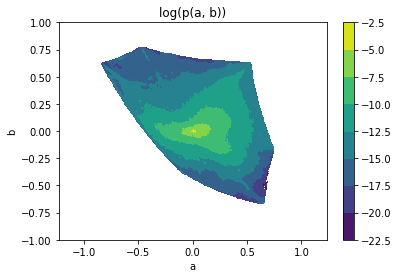

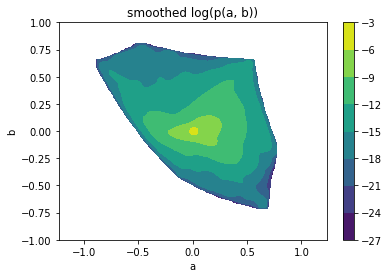

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def map_ab_into_int(ab):
  return tf.cast(
      tf.minimum(tf.maximum(tf.math.round(ab * 128.) + 128., 0.), 255.),
      tf.dtypes.int32)

def map_ab_into_bucket(ab):
  ab = map_ab_into_int(ab)
  ab = ab[..., 0] * 256 + ab[..., 1]
  return ab

#swap to false when file exists
if True:
  assert EFFECTIVE_COLOR_SPACE == 'lab'
  # Loop through all training set for counting the probability of (a, b)
  counts = tf.zeros(65536, tf.dtypes.int64)
  i = 0
  for x, _ in raw_training_dataset.batch(BATCH_SIZE):
    x = tf.cast(x, tf.dtypes.float32) / 255.
    _, ab = transform_from_rgb_color_space_and_decompose(x, EFFECTIVE_COLOR_SPACE)
    # Maps into integers in [0, 65536). 2^16 buckets for possibility estimatation.
    ab = map_ab_into_bucket(ab)
    count = tf.cast(tf.math.bincount(ab), tf.int64)
    if count.shape[0] < 65536:
      count = tf.concat([count, tf.zeros(65536 - count.shape[0], dtype=tf.dtypes.int64)], axis=-1)
    counts += count
    i += 1
    if i % 5000 == 0:
      print(f'Finished {i * BATCH_SIZE} examples')
  probability = tf.reshape(
      tf.cast(counts, tf.float32) / tf.cast(tf.reduce_sum(counts), tf.float32),
      (256, 256))
else:
  probability = np.load('/content/drive/MyDrive/cs229_models/efficient_net_colorizer_v2/ab_probability_256x256.npy')

def plot_2d(distribution, name='', log_scale=False):
  '''
  Plot 2d distribution of (a, b)
  '''
  b, a = np.meshgrid(np.linspace(-1, 1, 256), np.linspace(-1, 1, 256))
  plt.contourf(b, a, tf.math.log(distribution) if log_scale else distribution)
  plt.axis('equal')
  plt.xlabel('a')
  plt.ylabel('b')
  plt.colorbar()
  plt.title(name)
  plt.show()

FILTER_SHAPE = (10, 10)
GAUSSIAN_SIGMA = 5

plot_2d(probability, 'log(p(a, b))', log_scale=True)
smooth_probability = tfa.image.gaussian_filter2d(probability, FILTER_SHAPE, sigma=GAUSSIAN_SIGMA)
plot_2d(smooth_probability, 'smoothed log(p(a, b))', log_scale=True)

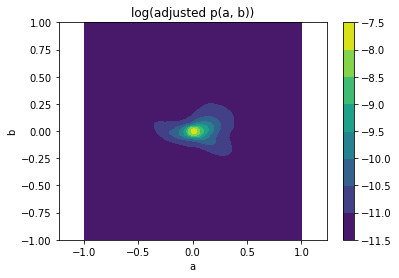

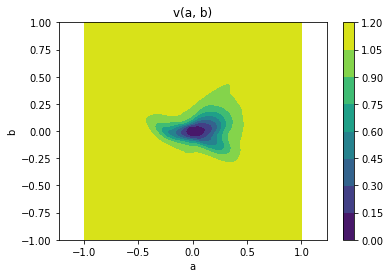

In [ ]:
LAMBDA = 0.9

adjusted_probability = (1 - LAMBDA) * smooth_probability + LAMBDA / (probability.shape[0] * probability.shape[1])
plot_2d(adjusted_probability, 'log(adjusted p(a, b))', log_scale=True)

ab_weight = 1 / adjusted_probability
ab_weight = ab_weight / tf.reduce_sum(ab_weight * adjusted_probability)
plot_2d(ab_weight, 'v(a, b)', log_scale=False)

###### Neural Network

In [ ]:
ab_weight = tf.reshape(ab_weight, (256 * 256, 1))

def rebalanced_loss_function(y_true, y_pred):
  weight = tf.nn.embedding_lookup(ab_weight, map_ab_into_bucket(y_true))
  return tf.reduce_mean(
      weight * tf.math.squared_difference(y_true, y_pred),
      axis=(-1, -2, -3))

efficient_net_colorizer_v2, efficient_net = build_efficient_net_colorizer()
efficient_net_colorizer_v2.compile(optimizer=tf.keras.optimizers.Adam(), loss=rebalanced_loss_function, metrics=['accuracy'])
efficient_net_colorizer_v2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 tf.image.grayscale_to_rgb_5 (T  (None, 224, 224, 3)  0          ['input_12[0][0]']               
 FOpLambda)                                                                                       
                                                                                                  
 tf.math.multiply_5 (TFOpLambda  (None, 224, 224, 3)  0          ['tf.image.grayscale_to_rgb_5[0][
 )                                                               0]']                       

In [ ]:
# Load saved model weights.
efficient_net_colorizer_v2.load_weights(get_saved_model_path('efficient_net_colorizer_v2'))

In [ ]:
efficient_net_colorizer_v2_checkpoint_path = get_checkpoint_path('efficient_net_colorizer_v2')

In [ ]:
import datetime

assert EFFECTIVE_COLOR_SPACE == 'lab'

# Create a callback that saves the model's weights
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=efficient_net_colorizer_v2_checkpoint_path,
    save_weights_only=True,
    verbose=1)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    f'/tmp/tensorboard_logs/efficient_net_colorizer_v2/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}',
    histogram_freq=1)

history = efficient_net_colorizer_v2.fit(
    training_dataset,
    validation_data=validation_dataset,
    shuffle=True,
    epochs=10,
    callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/10
1691/1691 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.6747
Epoch 1: saving model to /content/drive/MyDrive/cs229_model_checkpoints/efficient_net_colorizer_v2/places_model_01_0.006129.hdf5
1691/1691 [==============================] - 876s 507ms/step - loss: 0.0059 - accuracy: 0.6747 - val_loss: 0.0061 - val_accuracy: 0.6873
Epoch 2/10
1691/1691 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.6784
Epoch 2: saving model to /content/drive/MyDrive/cs229_model_checkpoints/efficient_net_colorizer_v2/places_model_02_0.006089.hdf5
1691/1691 [==============================] - 848s 501ms/step - loss: 0.0056 - accuracy: 0.6784 - val_loss: 0.0061 - val_accuracy: 0.6861
Epoch 3/10
1691/1691 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 0.6815
Epoch 3: saving model to /content/drive/MyDrive/cs229_model_checkpoints/efficient_net_colorizer_v2/places_model_03_0.005801.hdf5
1691/1691 [==============================] - 

## Evaluation

We are going to apply the trained model on a few images from validation (or test if exists) dataset and local to get the direct perception of how the performance is.

### Evalution Single Model

#### Test Data Set

In [ ]:
# Select the model used for evaluation.
assert EFFECTIVE_COLOR_SPACE == 'lab'
model = cnn_model_naive #Troy_Net_colorizer

Showing 8 samples from test set


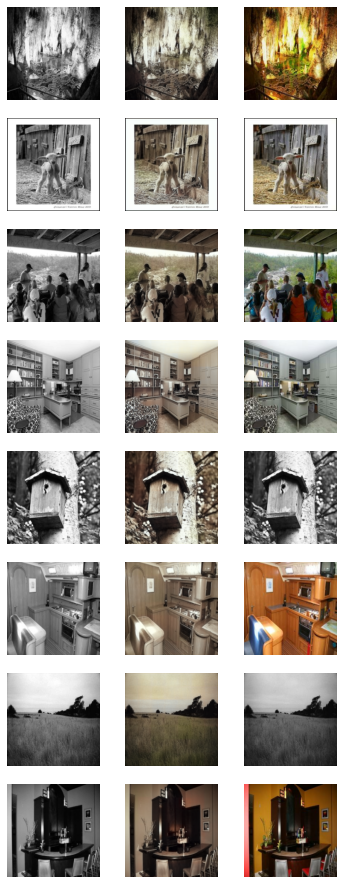

In [ ]:
import random

evaluation_dataset = validation_dataset
evaluation_dataset_name = 'validation set'
if 'test_dataset' in locals():
  evaluation_dataset = test_dataset
  evaluation_dataset_name = 'test set'

plt.figure(figsize=(6, 16))
for x, y in evaluation_dataset.skip(random.randint(0, 128)).take(1):
  n = min(x.shape[0], 8)

  y_pred = model.predict(x)

  indicies = list(range(x.shape[0]))
  random.shuffle(indicies)
  print(f'Showing {n} samples from {evaluation_dataset_name}')
  for t in range(n):
    i = indicies[t]
    # x: input, grayscale
    plt.subplot(8, 3, t * 3 + 1)
    plt.imshow(tf.squeeze(x[i]), cmap='gray')
    plt.axis('off')
    # y_pred: prediction
    plt.subplot(8, 3, t * 3 + 2)
    plt.imshow(compose_and_transform_to_rgb_color_space((x[i], y_pred[i]), EFFECTIVE_COLOR_SPACE))
    plt.axis('off')
    # y: ground truth
    plt.subplot(8, 3, t * 3 + 3)
    plt.imshow(compose_and_transform_to_rgb_color_space((x[i], y[i]), EFFECTIVE_COLOR_SPACE))
    plt.axis('off')

#### Manually Uploaded Data Set

Saving test 2.jpg to test 2 (3).jpg
Saving test 3.jpg to test 3 (3).jpg
Saving test1.jpg to test1 (3).jpg


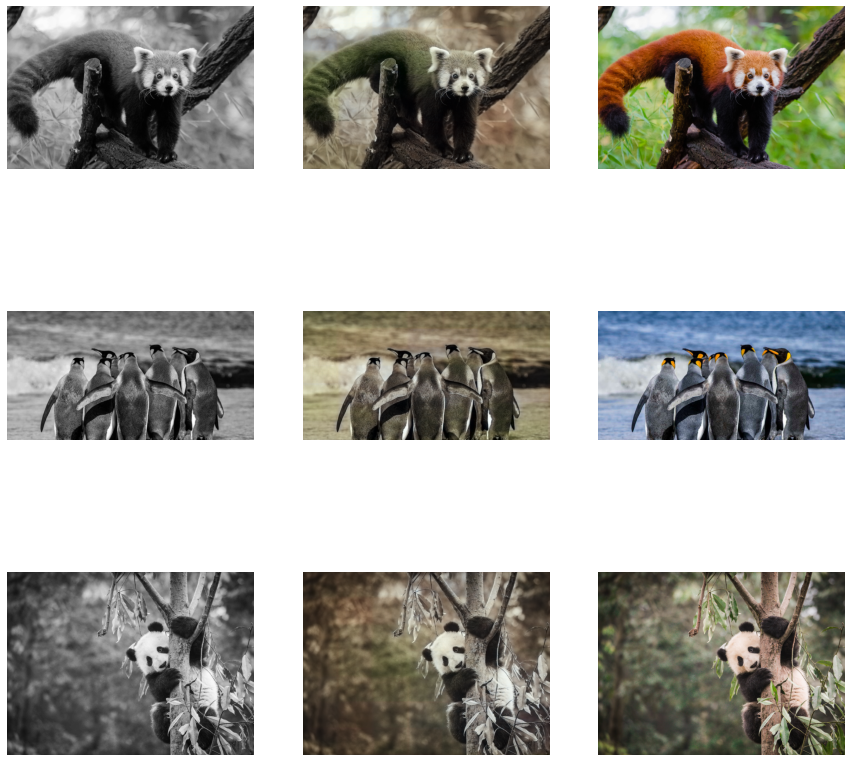

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()
filenames = list(uploaded.keys())
n = len(filenames)

plt.figure(figsize=(15, 5 * n))
for i in range(n):
  original = plt.imread(filenames[i])
  assert original.ndim == 2 or original.ndim == 3
  height, width = original.shape[0], original.shape[1]
  if original.ndim == 2:
    original = tf.reshape(original, (height, width, 1))

  # Normalize the input.
  image = tf.cast(original, tf.dtypes.float32)
  # It could be 3-channel or 1-channel image.
  if image.ndim == 3 and image.shape[2] == 3:
    image = tf.image.rgb_to_grayscale(image)
  if not (image.ndim == 3 and image.shape[2] == 1):
    raise ValueError(f'Unexpected image shape: {image.shape}')
  # Scale into [0, 1].
  image = image / 255.
  # Resize to (224, 224).
  image_224x224 = tf.image.resize(image, (224, 224))

  x = image_224x224
  y_pred = model.predict(tf.expand_dims(x, axis=0))[0]
  # x: input, grayscale
  plt.subplot(n, 3, i * 3 + 1)
  plt.imshow(tf.squeeze(image), cmap='gray')
  plt.axis('off')
  # y_pred: prediction
  plt.subplot(n, 3, i * 3 + 2)
  plt.imshow(compose_and_transform_to_rgb_color_space((image, tf.image.resize(y_pred, (height, width))), EFFECTIVE_COLOR_SPACE))
  plt.axis('off')
  # original: the original uploaded image
  plt.subplot(n, 3, i * 3 + 3)
  if original.shape[2] == 1:
    plt.imshow(tf.squeeze(original), cmap='gray', vmin=0, vmax=255)
  else:
    plt.imshow(original)
  plt.axis('off')

### Compare All Models

#### Test Data Set

In [ ]:
import random

evaluation_dataset = raw_validation_dataset
evaluation_dataset_name = 'validation set'
if 'test_dataset' in locals():
  evaluation_dataset = raw_test_dataset
  evaluation_dataset_name = 'test set'

models = [cnn_model_naive, vgg16_colorizer, efficient_net_colorizer, efficient_net_colorizer_v2]
color_spaces = ['lab', 'yuv', 'lab', 'lab']


rand = random.randint(0, 328000)
n = 32
m = len(models) + 2
scale = 5
plt.figure(figsize=(scale * m, scale * n))
print(f'Showing {n} samples from {evaluation_dataset_name}, range from {rand} to {rand + n}')
i = 0
for image, _ in evaluation_dataset.skip(rand).take(n):
  image = tf.image.resize(tf.cast(image, tf.dtypes.float32), (224, 224)) / 255.
  x = transform_from_rgb_color_space_and_decompose(image, 'lab')[0]
  # x: input, grayscale
  plt.subplot(n, m, i * m + 1)
  plt.imshow(tf.squeeze(x), cmap='gray')
  plt.axis('off')

  for j in range(len(models)):
    y_pred = models[j].predict(tf.expand_dims(x, axis=0))[0]
    # y_pred: prediction
    plt.subplot(n, m, i * m + 2 + j)
    plt.imshow(compose_and_transform_to_rgb_color_space((x, y_pred), color_spaces[j]))
    plt.axis('off')

  # y: ground truth
  plt.subplot(n, m, i * m + m)
  plt.imshow(image)
  plt.axis('off')

  i += 1

Showing 32 samples from test set, range from 285420 to 285452


<Figure size 1080x11520 with 0 Axes>

## References

1.   *Automatic Colorization*,
Ryan Dahl, https://tinyclouds.org/colorize/

2.   *ImageNet: A Large-Scale Hierarchical Image Database*,
Jia Deng, Wei Dong, Richard Socher, Li-Jia Li, Kai Li and Li Fei-Fei, 2009.

3.   *Colorful Image Colorization*,
Richard Zhang, Phillip Isola, Alexei A. Efros,
In European Conference on Computer Vision, 2016.

4.   *Deep Koalarization: Image Colorization using CNNs and Inception-ResNet-v2*,
Federico Baldassarre, Diego González Morín, Lucas Rodés-Guirao,
https://arxiv.org/abs/1712.03400

5.   *Places: A 10 million Image Database for Scene Recognition*,
B. Zhou, A. Lapedriza, A. Khosla, A. Oliva, and A. Torralba,
IEEE Transactions on Pattern Analysis and Machine Intelligence, 2017

6.   *Food-101 -- Mining Discriminative Components with Random Forests*,
Lukas Bossard, Matthieu Guillaumin, Luc Van Gool,
European Conference on Computer Vision, 2014

